In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

# NN models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from tqdm import tqdm
import glob
from sklearn.metrics import accuracy_score

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Get path to data directory
import os
workingdir = os.path.abspath(os.getcwd())
datadir = workingdir + '\data'

#### Get path to facial expression datasets

In [3]:
expressiondir = datadir + "\\facial_expressions"

In [4]:
expressiondir

'D:\\covidhackathon\\data\\facial_expressions'

In [7]:
datafile = expressiondir + '/data/legend.csv'
datafile2 = expressiondir + '/data/legend2.csv'
imagedir = expressiondir + '\\images'

## Parameters. Load Data

In [18]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL = 350, 350, 3
NUM_CLASSES = 3; 
facevalue = {'negative': 0, 'happiness': 1, 'neutral': 2}
emotionweights = {0:1, 1:1.2, 2:5.3}

def DecodeJPG(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

def ProcessFiles(data_id, im_filename, emotion):
    full_filename = imagedir + '\\' + im_filename
    img = tf.io.read_file(full_filename)
    img = DecodeJPG(img)
    return img, emotion

In [19]:
file_labels = tf.data.experimental.CsvDataset(datafile, record_defaults=[tf.string, tf.string, tf.int32], header=True).shuffle(10000)

In [20]:
img_labels = file_labels.map(ProcessFiles, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64).repeat()
img_labels_val = img_labels.take(2000)
img_labels_tra = img_labels.skip(2000)

In [21]:
iterator = img_labels.make_initializable_iterator()
next_op = iterator.get_next()

In [22]:
with tf.Session() as sess:
    sess.run(iterator.initializer)
    sess.run(tf.tables_initializer())
    img, lab = sess.run(next_op)
    print(lab)

[1 2 1 2 1 1 2 1 1 2 1 2 2 2 2 2 2 1 2 2 2 2 0 2 2 1 2 1 1 2 2 1 1 1 1 1 1
 2 1 1 1 2 2 2 2 1 2 2 1 1 2 2 1 0 2 1 1 2 1 1 2 2 2 2]


In [23]:
lab

array([1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       0, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2,
       2, 1, 2, 2, 1, 1, 2, 2, 1, 0, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2])

## Train Model

In [145]:
#We will create a simple architecture with 2 convolutional layers, one dense hidden layer and an output layer.
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),strides = (2,2), padding = 'same', activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNEL)))
model.add(Conv2D(64, (3, 3), strides = (2,2), activation='relu'))
model.add(Conv2D(64, (3, 3), strides = (2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

In [146]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [147]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 175, 175, 32)      896       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 87, 87, 64)        18496     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 43, 43, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 28224)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               3612800   
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 387       
Total para

In [148]:
history = model.fit(x=img_labels_tra, epochs=10, steps_per_epoch=100, verbose=1, validation_data=img_labels_val, validation_steps = 20)

Epoch 1/10
100/100 [==============================] - 342s 3s/step - loss: 0.8841 - acc: 0.5455 - val_loss: 0.7003 - val_acc: 0.7203
Epoch 2/10
100/100 [==============================] - 166s 2s/step - loss: 0.6551 - acc: 0.7301 - val_loss: 0.5518 - val_acc: 0.7734
Epoch 3/10
100/100 [==============================] - 161s 2s/step - loss: 0.6098 - acc: 0.7475 - val_loss: 0.5771 - val_acc: 0.8008
Epoch 4/10
100/100 [==============================] - 159s 2s/step - loss: 0.5622 - acc: 0.7813 - val_loss: 0.5331 - val_acc: 0.7969
Epoch 5/10
100/100 [==============================] - 161s 2s/step - loss: 0.5373 - acc: 0.7830 - val_loss: 0.4943 - val_acc: 0.8117
Epoch 6/10
100/100 [==============================] - 164s 2s/step - loss: 0.4983 - acc: 0.8039 - val_loss: 0.4890 - val_acc: 0.7953
Epoch 7/10
100/100 [==============================] - 165s 2s/step - loss: 0.4786 - acc: 0.8055 - val_loss: 0.5165 - val_acc: 0.8000
Epoch 8/10
100/100 [==============================] - 160s 2s/step - 

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


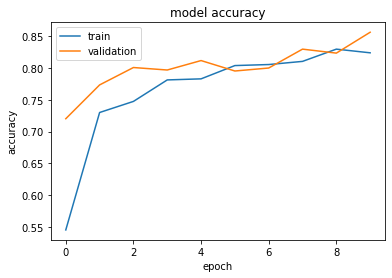

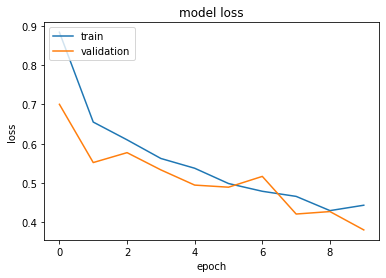

In [150]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [198]:
model.save('initialmodelthree')

## Test Model

In [26]:
model = load_model('initialmodelthree')

In [27]:
iterator = img_labels_val.make_initializable_iterator()
next_op = iterator.get_next()
img_lst, lab_lst = [], []
with tf.Session() as sess:
    sess.run(iterator.initializer)
    sess.run(tf.tables_initializer())
    for _ in range(10):
        img, lab = sess.run(next_op)
        img_lst.append(img)
        lab_lst.append(lab)

In [28]:
acc_lst = []
acc_2nd = []
for img, lab in zip(img_lst, lab_lst):
    pred = model.predict_classes(img)
    acc_lst.append(np.mean(np.equal(lab, pred)))
    acc_2nd.append(accuracy_score(lab,pred))

In [29]:
acc_lst

[0.90625,
 0.875,
 0.875,
 0.921875,
 0.875,
 0.828125,
 0.859375,
 0.8125,
 0.9375,
 0.875]

In [30]:
acc_2nd

[0.90625,
 0.875,
 0.875,
 0.921875,
 0.875,
 0.828125,
 0.859375,
 0.8125,
 0.9375,
 0.875]

In [40]:
datafile2

'D:\\covidhackathon\\data\\facial_expressions/data/legend2.csv'

In [41]:
file_labels_test = tf.data.experimental.CsvDataset(datafile2, record_defaults=[tf.string, tf.string, tf.int32], header=True).shuffle(10000)
img_labels = file_labels_test.map(ProcessFiles, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(128).repeat()

In [45]:
iterator = img_labels_val.make_initializable_iterator()
next_op = iterator.get_next()
img_lst, lab_lst = [], []
with tf.Session() as sess:
    sess.run(iterator.initializer)
    sess.run(tf.tables_initializer())
    for _ in range(4):
        img, lab = sess.run(next_op)
        img_lst.append(img)
        lab_lst.append(lab)

In [123]:
acc_lst = []
predictions = []
for img, lab in zip(img_lst, lab_lst):
    pred = model.predict_classes(img)
    pred2 = model.predict(img)
    predictions.append(pred2)
    acc_lst.append(accuracy_score(lab,pred))
predictions = predictions[0]

In [124]:
acc_lst

[0.859375, 0.953125, 0.921875, 0.875]

In [125]:
print('Accuracy on test data:', np.mean(acc_lst))

Accuracy on test data: 0.90234375


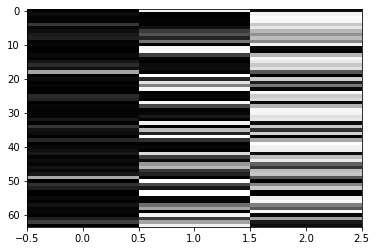

In [126]:
plt.imshow(np.stack(predictions, axis=0), aspect = 'auto', cmap = 'gray')

# Now trying it on your own data!

In [237]:
img_list = glob.glob('data\MyFaces/*.png')

Original Image


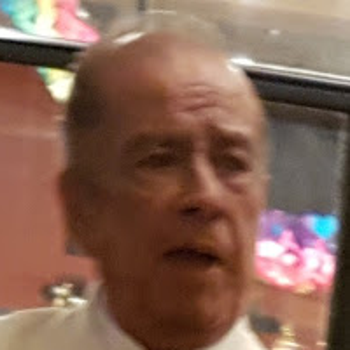

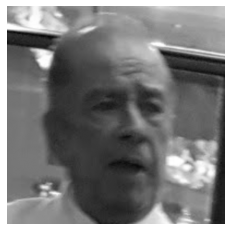

This person is showing negative


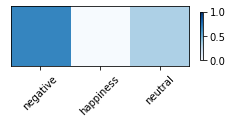

In [240]:
tograyscale = True;

for img_file in img_list[:1]:
    img = Image.open(img_file)
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))
    print('Original Image'); display(img); 
    
    if tograyscale:
        img = img.convert('L').convert('RGB')
        im = np.asarray(img)
    else:
        im = np.asarray(img)
        im = im[:,:,:3]
    im = im/255
    im_input = im.reshape((1,350,350,3))
    
    pred_class = model.predict_classes(im_input)[0]
    pred_class = list(facevalue.keys())[pred_class]
    label = model.predict(im_input)[0]
    
    plt.imshow(im); plt.axis('off');
    plt.show(); 

    print('This person is showing', list(facevalue.keys())[label.argmax()])
    plt.figure(figsize = (4,9))
    plt.imshow(label.reshape(1,3), vmax = 1, vmin= 0, cmap = 'Blues'); 
    plt.yticks([]); plt.xticks(np.arange(3), list(facevalue.keys()), rotation = 45); plt.colorbar(shrink = .1); plt.show()